### **Positive and negative sentence classification model in 2, 3 and 4 star review comments**

In [1]:
%%capture
!pip install -r ../requirements.txt

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import fasttext
import re
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.cluster.util import cosine_distance
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn import model_selection, svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
df_raw = pd.read_csv('../data/raw/Big_AHR.csv')

In [4]:
df_3_stars = df_raw[df_raw['rating']==3]

In [15]:
for text in df_3_stars['review_text'].sample(5).tolist():
    print(text)
    print()

Está bien situado, aunque las calles de alrededor son muy sucias...por la noche se oía ruido de la calle. Tuvimos bichos en la habitación, aunque el personal fumigó y nos ofreció el cambio la situación fue algo desagradable. Aun así, tiene buen precio y buen desayuno (merece la pena cogerlo).

La ubicación es perfecta, entra el acceso a la Alcazaba y la Catedral. Puedes recorrer todo el centro e ir a la playa de la Malagueta y la zona del MuelleUno andando. El parking está a escasos metros y el acceso al mismo y las plazas son correctos. La habitación daba a un patio interior y era tranquila. El hotel está algo antiguo, pero cumple para una estancia de ciudad. Alrededor hay muchos establecimientos para desayunar, comer y cenar.

La posada Doña Lupe se puede ver de muchas maneras. No es un lugar para estarse en las habitaciones, ya que éstas sólo sirven para dormir y gracias. Está poco cuidado (faltaban muchas bombetas, por ejemplo) y se podría decir que la limpieza era la justa. Aún as

In this sample of neutral reviews, it can be seen that the comments highlight both positive and negative aspects.
Therefore, each comment will be separated into sentences, with the aim of being classified as positive or negative.

The division of each comment into sentences and the text processing was done *using create_df_sentences.py*

In [137]:
df_sentences_1_star = pd.read_csv('../data/interim/sentences_1_star.csv')
df_sentences_5_stars = pd.read_csv('../data/interim/sentences_5_stars.csv')

All sentences belonging to 5-star reviews will be assumed to be positive, and all sentences belonging to 1-star reviews will be assumed to be negative. While this is not strictly true, it will allow the model to be built.

In [6]:
len(df_sentences_1_star)

11885

In [7]:
len(df_sentences_5_stars)

53205

In [7]:
# Take a sample of positive sentences to equate both categories
df_sentences_5_stars = df_sentences_5_stars.sample(len(df_sentences_1_star))

In [9]:
print('Examples of negative sentences:')
df_sentences_1_star.sample(3)

Examples of negative sentences:


,text,review_index,text_processed
6117,Dejadez,928,dejadez
11294,Voy a hacer el checkout sin poder desayunar,1601,voy hacer checkout sin poder desayunar
2029,Vale,321,vale


In [10]:
print('Examples of positive sentences:')
df_sentences_5_stars.sample(3)

Examples of positive sentences:


,text,review_index,text_processed
41182,Totalmente recomendables,7145,totalmente recomendables
26555,"Cenamos en el restaurante del hotel, muy buena...",4686,cenamos restaurante buena comida buen precio
8642,El tablao flamenco que ofrece el mismo hotel n...,1549,tablao flamenco ofrece mismo encanto


In [11]:
# Add column to indicate sentiment
df_sentences_1_star['label'] = 'Negative'
df_sentences_5_stars['label'] = 'Positive'

In [12]:
# Combine positive and negative sentences into one df
df_sentences_labeled = pd.concat([df_sentences_1_star, df_sentences_5_stars]).reset_index(drop=True)

In [13]:
df_sentences_labeled['label'] = df_sentences_labeled['label'].astype('category')

In [16]:
# Delete empty rows
df_clean = df_sentences_labeled[df_sentences_labeled.text_processed.notna()]

##### **Training and evaluation of the model for sentences classification**

In [17]:
X = df_clean['text_processed']
y = df_clean['label']

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=18)

In [51]:
classifier = Pipeline([
    ('count_vectorizer', CountVectorizer(max_features=1000, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('model', SVC(kernel='rbf', probability=True))
])

In [52]:
classifier.fit(X_train, y_train)

Pipeline(steps=[('count_vectorizer',
                 CountVectorizer(max_features=1000, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('model', SVC(probability=True))])

In [53]:
y_pred = classifier.predict(X_val)

In [54]:
classifier.score(X_train, y_train)

0.931748726655348

In [55]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

    Negative       0.85      0.89      0.87      2935
    Positive       0.89      0.84      0.86      2955

    accuracy                           0.87      5890
   macro avg       0.87      0.87      0.87      5890
weighted avg       0.87      0.87      0.87      5890



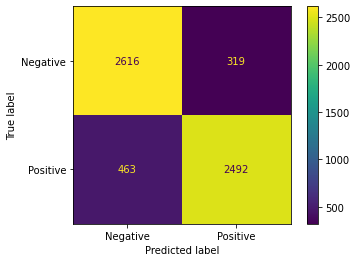

In [56]:
cm = confusion_matrix(y_val, y_pred, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()

In [ ]:
# Save model
filename = '../models/sentences_classification.pkl'
pickle.dump(classifier, open(filename,'wb'))

##### **Application of the model to sentences corresponding to 2-star reviews**

In [ ]:
df_sentences_2_stars = pd.read_csv('../data/interim/sentences_2_stars.csv')

In [ ]:
df_2_stars = df_sentences_2_stars[df_sentences_2_stars.text_processed.notna()]
X_2_stars = df_2_stars['text_processed']
y_2_stars = classifier.predict(X_2_stars)
df_y_2_stars = pd.DataFrame({'label':y_2_stars})
predictions_2_stars = pd.concat([X_2_stars.reset_index(), df_y_2_stars.reset_index()], axis=1).drop(columns=['index'], axis=1)

In [ ]:
predictions_2_stars.sample(5)

,text_processed,label
6397,sintesis bien ubicado siendo bien refaccionado...,Positive
5937,unica limpieza hacen habitacion dia fregar sue...,Negative
4246,banera tapon roto,Negative
6859,peor aparcamiento aparcarlo calles colindantes...,Negative
1444,habitaciones pobres sabanas manchadas camas fl...,Negative


In [ ]:
predictions_2_stars.label.value_counts()

Negative    5406
Positive    1777
Name: label, dtype: int64

In [ ]:
print(f'Predicted percentage of negative sentences: {round((100*5406)/(5406+1777))}%')
print(f'Predicted percentage of positive sentences: {round((100*1777)/(5406+1777))}%')

Predicted percentage of negative sentences: 75%
Predicted percentage of positive sentences: 25%


##### **Application of the model to sentences corresponding to 3-star reviews**

In [ ]:
df_sentences_3_stars = pd.read_csv('../data/interim/sentences_3_stars.csv')

In [122]:
df_3_stars = df_sentences_3_stars[df_sentences_3_stars.text_processed.notna()]

In [123]:
X_3_stars = df_3_stars['text_processed']

In [124]:
y_3_stars = classifier.predict(X_3_stars)

In [125]:
df_y_3_stars = pd.DataFrame({'label':y_3_stars})

In [126]:
predictions_3_stars = pd.concat([X_3_stars.reset_index(), df_y_3_stars.reset_index()], axis=1).drop(columns=['index'], axis=1)

In [127]:
predictions_3_stars.sample(5)

,text_processed,label
8459,buena ubicacion,Positive
9751,puede aparcar facil cerca,Positive
2636,habitacion q dice ser 3,Negative
3581,bano no muestra fotos,Negative
7232,bien situado,Positive


In [128]:
predictions_3_stars.label.value_counts()

Negative    7466
Positive    7276
Name: label, dtype: int64

In [103]:
print(f'Predicted percentage of negative sentences: {round((100*7466)/(7466+7276))}%')
print(f'Predicted percentage of positive sentences: {round((100*7276)/(7466+7276))}%')

Predicted percentage of negative sentences: 51%
Predicted percentage of positive sentences: 49%


##### **Application of the model to sentences corresponding to 4-star reviews**

In [110]:
df_sentences_4_stars = pd.read_csv('../data/interim/sentences_4_stars.csv')

In [111]:
df_4_stars = df_sentences_4_stars[df_sentences_4_stars.text_processed.notna()]
X_4_stars = df_4_stars['text_processed']
y_4_stars = classifier.predict(X_4_stars)
df_y_4_stars = pd.DataFrame({'label':y_4_stars})
predictions_4_stars = pd.concat([X_4_stars.reset_index(), df_y_4_stars.reset_index()], axis=1).drop(columns=['index'], axis=1)

In [113]:
predictions_4_stars.sample(5)

,text_processed,label
22754,experiencia valiosa,Positive
21052,volveremos,Positive
13801,presentaba limpieza higiene medidas desinfecci...,Positive
994,creo precio alto no encuentras ofertas,Negative
19346,no acudia pension hacia decadas salio paso bus...,Negative


In [115]:
predictions_4_stars.label.value_counts()

Positive    18925
Negative     6290
Name: label, dtype: int64

In [116]:
print(f'Predicted percentage of negative sentences: {round((100*18925)/(18925+6290))}%')
print(f'Predicted percentage of positive sentences: {round((100*6290)/(18925+6290))}%')

Predicted percentage of negative sentences: 75%
Predicted percentage of positive sentences: 25%


##### **Create datasets of positive and negative sentences**

Negative sentences

In [118]:
df_sentences_1_star = df_sentences_1_star.drop(columns=['text', 'review_index'], axis=1)

In [131]:
df_negative_sentences = pd.concat([df_sentences_1_star.reset_index(), predictions_2_stars[predictions_2_stars['label']=='Negative'].reset_index(), predictions_3_stars[predictions_3_stars['label']=='Negative'].reset_index(), predictions_4_stars[predictions_4_stars['label']=='Negative'].reset_index()])

In [133]:
df_negative_sentences = df_negative_sentences.drop(columns=['index'], axis=1)

In [135]:
df_negative_sentences.to_csv('../data/processed/negative_sentences.csv')

Positive sentences

In [138]:
df_sentences_5_stars = df_sentences_5_stars.drop(columns=['text', 'review_index'], axis=1)

In [139]:
df_positive_sentences = pd.concat([df_sentences_5_stars.reset_index(), predictions_2_stars[predictions_2_stars['label']=='Positive'].reset_index(), predictions_3_stars[predictions_3_stars['label']=='Positive'].reset_index(), predictions_4_stars[predictions_4_stars['label']=='Positive'].reset_index()])

In [140]:
df_positive_sentences = df_positive_sentences.drop(columns=['index'], axis=1)

In [141]:
df_positive_sentences.to_csv('../data/processed/positive_sentences.csv')